# Fuzzy C-Means Clustering

In [41]:
# Library imports
import numpy as np
import pandas as pd
import math
from functools import reduce
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [42]:
# Data imports
raw_data_csv = []
raw_data_csv.append(pd.read_csv("data/data1.csv", header=None))
raw_data_csv.append(pd.read_csv("data/data2.csv", header=None))
raw_data_csv.append(pd.read_csv("data/data3.csv", header=None))
raw_data_csv.append(pd.read_csv("data/data4.csv", header=None))

In [43]:
## Definition of constants
CONST_M = 1.4
CONST_CLUSTERING_ITERATION_NUMBER = 70

## Functions

### Distance
Distance function uses euclidean distance.

point p and q in n-space.
$$
d(p,q) = \sqrt{\sum_{i=1}^n (q_i - p_i)^2 }
$$

### Update Membership Values
Uses following formula:

$$
u_{ik} = \frac{\left(\frac{1}{|| X_k - V_i ||}\right)^{\frac{2}{m-1}}}{\sum_{j=0}^c \left(\frac{1}{|| X_k - V_j ||}\right)^{\frac{2}{m-1}}}
$$


$u_{ik}$ is membership value of k-th data to i-th cluster:

$V_i$ is center of i-th cluster

$X_i$ is i-th data point

$m$ is fuzziness

$N$ is number of data points

###  Update Clusters Center
Uses following formula:

$$
V_{i} = \frac{\sum_{k=1}^{N} u_{ik}^m X_k}{\sum_{k=1}^{N} u_{ik}^m}
$$


$u_{ik}$ is membership value of k-th data to i-th cluster:

$V_i$ is center of i-th cluster

$X_k$ is k-th data point

$m$ is fuzziness

$N$ is number of data points

### Cost Funcion
Uses following formula:

$$
J = \sum_{j=1}^{N} \sum_{i=1}^{c} u_{ij}^m || X_j - V_i ||^2
$$


$u_{ij}$ is membership value of j-th data to i-th cluster:

$V_i$ is center of i-th cluster

$X_j$ is j-th data point

$m$ is fuzziness

$N$ is number of data points

### Defuzzification
Uses maximum membership value for crisp clustering.

In [44]:
def distance(point1, point2, to_power2=False):
    assert len(point1) == len(point2), "Points dimentions are different."
    
    dist = 0;
    for i in range(len(point1)):
        dist = dist + (point1[i] - point2[i])**2
        
    return dist if to_power2 else math.sqrt(dist)


def choose_random(data, number_of_samples):
    sample_dataframe = data.sample(n = number_of_samples)
    return sample_dataframe.iloc[:,:-1] # cut the last column

def product_with_tuple(input_scalar, input_tuple):
    return tuple([ val * input_scalar for val in input_tuple ])
    
def sum_of_tuples(tuple1, tuple2):
    return tuple([ x + y for x, y in zip(tuple1,tuple2)])
    
    
def update_cluster_values(data, centroids):
    for data_index, data_row in data.iterrows():
        point = tuple(data_row[:-1]) # cut the last column and convert to tuple
                
        distance_sum_inverse = 0
        for center_tuple in centroids:
            distance_sum_inverse = distance_sum_inverse + (1 / (distance(point,center_tuple,to_power2=True))**(1/(CONST_M-1)) )
            
        belonging_value_to_clusters = []
        for center in centroids:
            numerator = 1 / (distance(point,center,to_power2=True))**(1/(CONST_M-1))    
            belonging_value_to_clusters.append(numerator/distance_sum_inverse)
      
        data.at[data_index,'fuzzy_cluster'] = belonging_value_to_clusters
        
    
def calculate_and_get_new_centers(data, centroids):
    new_centers = []
    
    for center_index, center in enumerate(centroids):
        
        belonging_values_sum = 0
        for data_index, data_row in data.iterrows():
            belonging_values_sum = belonging_values_sum + (data_row['fuzzy_cluster'][center_index])**CONST_M
        
        share_of_each_data_in_center = []
        for data_index, data_row in data.iterrows():
            point_share_in_center = (data_row['fuzzy_cluster'][center_index]**CONST_M) / belonging_values_sum
            share_of_each_data_in_center.append(product_with_tuple(point_share_in_center, data_row[:-1]))
            
        cluster_center = reduce(lambda t1, t2: sum_of_tuples(t1, t2), share_of_each_data_in_center)
        
        new_centers.append(cluster_center)
        
    return new_centers
        
def get_cost(data, centroids):
    cost = 0
    for data_index, data_row in data.iterrows():
        for center_index, center in enumerate(centroids):
            cost = cost + ((data_row['fuzzy_cluster'][center_index]**CONST_M) * distance(data_row[:-1], center, to_power2=True) )
    return cost

def defuzzification(data):
    crisp = []
    for data_index, data_row in data.iterrows():
        crisp.append(np.array(data_row['fuzzy_cluster']).argmax())
    return crisp

## construct an RGB colot for all data points based on each membership value.
def get_3_cluster_gradient(data):
    gradient = []
    for data_index, data_row in data.iterrows():
        values = (np.array(data_row['fuzzy_cluster']) * 255).tolist()
        values = tuple(map(round, values))
        gradient.append('#%02x%02x%02x' % values)
    return gradient



### Iterative Function
1. We chooshe some data point as initial centers of clusters.
1. Membership values are calcualted for each cluster based on cluster center.
1. Center of clusters are calculated based on membership values.
1. Go to second step ("CONST_CLUSTERING_ITERATION_NUMBER" times)

In [45]:
def fuzzy_C_means(input_data, clusters_number):
    input_data['fuzzy_cluster'] = [[]] * len(input_data)
    random_sample_dataframe = choose_random(input_data, clusters_number)
    centroids = [ tuple(d[1]) for d in random_sample_dataframe.iterrows()]
    input_data = input_data.drop(random_sample_dataframe.index) # delete selected rows because of adding additioanl comlplexity to clculation in fuctions (0 distance to itself)
        
    for iteration in range(CONST_CLUSTERING_ITERATION_NUMBER):
        update_cluster_values(input_data, centroids)
        centroids = calculate_and_get_new_centers(input_data, centroids)

    return (input_data, centroids, get_cost(input_data, centroids))


## Cost function and elbow method

We calculate cost function for $c = 0,1,2,... ,10$ for all data files. ($c=0$ is for simplifying the index in result and should be discarded.)

In [34]:
result = {}
for data_index, data in enumerate(raw_data_csv):
    print("processing next csv ...")
    data_result = []
    for c in range(10): 
        data_result.append(fuzzy_C_means(data, c))
    result[data_index] = data_result
    

processing next csv ...
processing next csv ...
processing next csv ...
processing next csv ...


<ipython-input-35-bd2066dbf82c>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


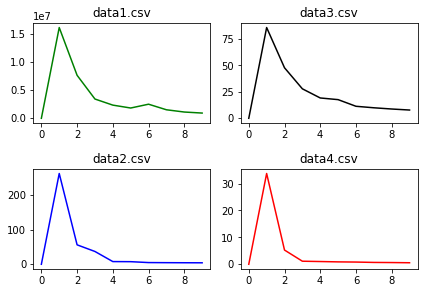

In [35]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].set_title('data1.csv')
ax[0, 0].plot([result[0][i][2] for i in range(10)], 'g')

ax[1, 0].set_title('data2.csv')
ax[1, 0].plot([result[1][i][2] for i in range(10)], 'b')

ax[0, 1].set_title('data3.csv')
ax[0, 1].plot([result[2][i][2] for i in range(10)], 'k')

ax[1, 1].set_title('data4.csv')
ax[1, 1].plot([result[3][i][2] for i in range(10)], 'r')

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.show()


### Conclusion
We choose best c for each dataset.

Based on these plots:


|data set | number of clusters
:--- | :---:
| data1.csv | 3 |
| data2.csv | 3 |
| data3.csv | 4 |
| data4.csv | 3 |




## Fuzziness Parameter

We try clustering with different values for m (Fuzziness) after that the cost function and clusters for each m will be plotted in order to analyze this parameter effect on clustering.

In [46]:
different_m_result = []
m_values = [ 1+(m/10) for m in range(1, 100, 7)]
for f in m_values:
    print("clustering with m = {}".format(f))
    CONST_M = f # DANGER: GLOABAL VARIABLE OVERWRITING ;)
    different_m_result.append(fuzzy_C_means(raw_data_csv[0], 3))
    

clustering with m = 1.1
clustering with m = 1.8
clustering with m = 2.5
clustering with m = 3.2
clustering with m = 3.9
clustering with m = 4.6
clustering with m = 5.3
clustering with m = 6.0
clustering with m = 6.7
clustering with m = 7.4
clustering with m = 8.1
clustering with m = 8.8
clustering with m = 9.5
clustering with m = 10.2
clustering with m = 10.9


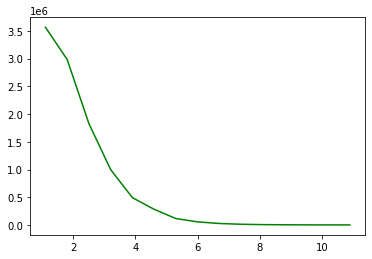

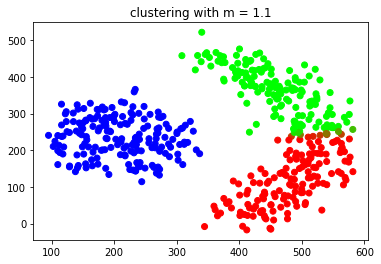

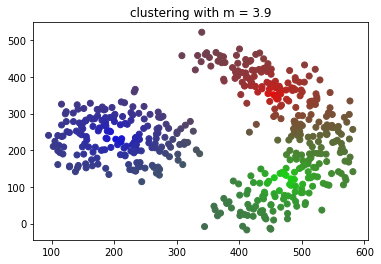

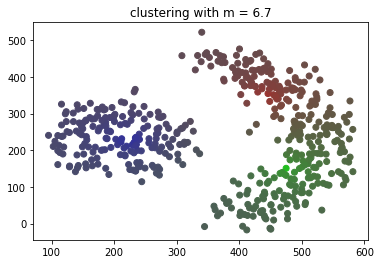

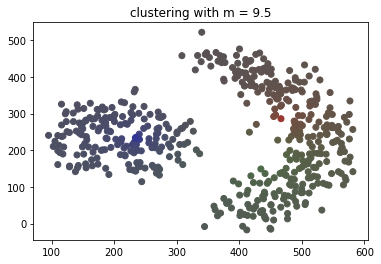

In [47]:
plt.plot(m_values,[different_m_result[i][2] for i in range(len(different_m_result))], 'g')
plt.show()

for i, m in enumerate(m_values):
    if i % 4 == 0: # because we don't want to plot all resluts
        plt.scatter(
            x=different_m_result[i][0][:][0],
            y=different_m_result[i][0][:][1],
            c=get_3_cluster_gradient(different_m_result[i][0]),
            cmap='gist_rainbow'
        )
        plt.gca().update(dict(title="clustering with m = {}".format(m)))
        plt.show()


### Analysis

$$
Cost = \sum_{j=1}^{N} \sum_{i=1}^{c} u_{ij}^m || X_j - V_i ||^2
$$

Generally if m is large number, we will approach to crisp model instead of fuzzy.

Here, because the m is between 0 and 1 so the more value for m gives less value for $u_{jk}^m$ and this reduces cost function value.

In this particular case beacase of following reasons, $m$ value hasn't much effect on clustering:

1. Clusters are far from each other.
1. Clusters are symmetical.

Actually if we use KNN instead of FCM, we will get the same result.

If we consider effect of $m$ on fuzzy clustering, we can say "higher value for $m$ makes the membership values  become closer to each other." (Softer)

## Plotting Results

### 2-D data

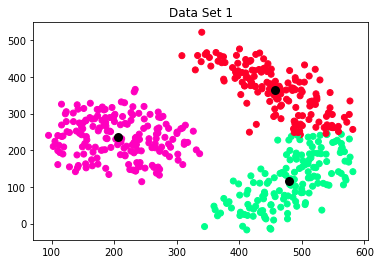

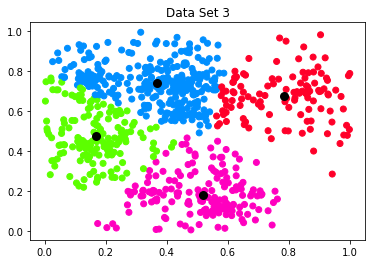

In [37]:

plt.scatter(
    x=result[0][3][0][:][0],
    y=result[0][3][0][:][1],
    c=defuzzification(result[0][3][0]),
    cmap='gist_rainbow'
)
for i in range(len(result[0][3][1])):
    plt.scatter(result[0][3][1][i][0], result[0][3][1][i][1], c='black',linewidths=3)
plt.gca().update(dict(title="Data Set 1"))
plt.show()


plt.scatter(
    x=result[2][4][0][:][0],
    y=result[2][4][0][:][1],
    c=defuzzification(result[2][4][0]),
    cmap='gist_rainbow'
)
for i in range(len(result[2][4][1])):
    plt.scatter(result[2][4][1][i][0], result[2][4][1][i][1], c='black',linewidths=3)
plt.gca().update(dict(title="Data Set 3"))
plt.show()


### 3-D Data

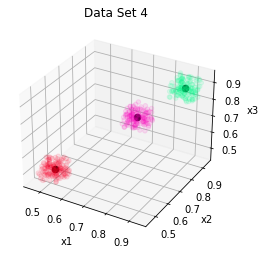

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
 
ax.scatter3D(
    xs=result[3][3][0][:][0],
    ys=result[3][3][0][:][1],
    zs=result[3][3][0][:][2],
    c=defuzzification(result[3][3][0]),
    cmap='gist_rainbow',
    alpha=0.1
)
for i in range(len(result[3][3][1])):
    ax.scatter3D(
        xs=result[3][3][1][i][0],
        ys=result[3][3][1][i][1],
        zs=result[3][3][1][i][2],
        c='black',
        linewidths=3
    )
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.gca().update(dict(title="Data Set 4"))
plt.show()

By: Ali Faraji (9634024)

Thank you